In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")

import textblob
from textblob import TextBlob

In [70]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eric.hoanshelt/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/eric.hoanshelt/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
data = pd.read_json("../data/raw/complaints-2021-05-14_08_16_.json")

In [3]:
data

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."
...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0,"{'tags': None, 'zip_code': '08857', 'complaint..."
78309,complaint-public-v2,complaint,3091984,0,"{'tags': None, 'zip_code': '934XX', 'complaint..."
78310,complaint-public-v2,complaint,3133355,0,"{'tags': None, 'zip_code': '923XX', 'complaint..."
78311,complaint-public-v2,complaint,3110963,0,"{'tags': None, 'zip_code': None, 'complaint_id..."


In [4]:
data["_type"].value_counts()

_type
complaint    78313
Name: count, dtype: int64

In [5]:
data["_index"].value_counts()

_index
complaint-public-v2    78313
Name: count, dtype: int64

In [6]:
data["_score"].value_counts()

_score
0    78313
Name: count, dtype: int64

In [7]:
df: pd.DataFrame = data["_source"].apply(pd.Series)

/var/folders/67/pb81vw6150zg1p9ptc37j0xr0000gn/T/ipykernel_9057/447349858.py:1: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df: pd.DataFrame = data["_source"].apply(pd.Series)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tags                       3816 non-null   object
 1   zip_code                   16427 non-null  object
 2   complaint_id               21072 non-null  object
 3   issue                      21072 non-null  object
 4   date_received              21072 non-null  object
 5   state                      20929 non-null  object
 6   consumer_disputed          21072 non-null  object
 7   product                    21072 non-null  object
 8   company_response           21072 non-null  object
 9   company                    21072 non-null  object
 10  submitted_via              21072 non-null  object
 11  date_sent_to_company       21072 non-null  object
 12  company_public_response    2 non-null      object
 13  sub_product                18963 non-null  object
 14  timely     

In [9]:
df.shape

(78313, 18)

In [10]:
df["complaint_what_happened"].head(50)

0                                                      
1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8                                                      
9                                                      
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
12                                                     
13                                                     
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
16                                                     
17    With out notice J.P. Morgan Chase restrict

We see we have a few records that are blank. We should clean those up by setting blank values to null and then dropping them

In [11]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [12]:
df = df[~df['complaint_what_happened'].isnull()]

In [13]:
df.shape

(21072, 18)

In [14]:
df["complaint_what_happened"].head(50)

1      Good morning my name is XXXX XXXX and I apprec...
2      I upgraded my XXXX XXXX card in XX/XX/2018 and...
10     Chase Card was reported on XX/XX/2019. However...
11     On XX/XX/2018, while trying to book a XXXX  XX...
14     my grand son give me check for {$1600.00} i de...
15                         Can you please remove inquiry
17     With out notice J.P. Morgan Chase restricted m...
20     During the summer months, I experience a decli...
21     On XXXX XX/XX/2019, I made a {$300.00} payment...
23     I have a Chase credit card which is incorrectl...
24     mishandling of this account by Chase auto and ...
26     I have reached out to XXXX several times in at...
27     I opened an account with chase bank on XXXX an...
30     To whom it may concern, Chase bank charged wro...
32     My chase amazon card was declined for a cateri...
35     I opened the saving account for the {$25.00} b...
40     XXXX XXXX a sofa, love seat, table and chairs ...
42     My card went missing and

In [21]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [27]:
def normalize_text(text_input):
    text_input = text_input.lower()
    pattern = '[^\w\s]' #Remove puncutations
    text_input = re.sub(pattern, '', text_input) 
    pattern = '\w*\d\w*' # Removing words with numbers in between
    text_input = re.sub(pattern, '', text_input) 
    return text_input

In [28]:
df_normalized = pd.DataFrame(df['complaint_what_happened'].apply(normalize_text))

In [29]:
df_normalized

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [47]:
def lemmmatize_text(text_input):
    sent = []
    doc = nlp(text_input)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [48]:
df_normalized["complaint_lemmatized"] = df_normalized["complaint_what_happened"].apply(lemmmatize_text)

In [49]:
df_normalized

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [64]:
def get_POS_tags(text_input):
    sent = []
    blob = TextBlob(text_input)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [67]:
df_normalized["complaint_POS_removed"] = df_normalized["complaint_lemmatized"].apply(get_POS_tags)

In [73]:
df_normalized['complaint_clean'] = df_normalized['complaint_POS_removed'].str.replace('-PRON-', '')

In [74]:
df_normalized

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...


## EDA with visuals

/Users/eric.hoanshelt/anaconda3/envs/banktickclass/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eric.hoanshelt/anaconda3/envs/banktickclass/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eric.hoanshelt/anaconda3/envs/banktickclass/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


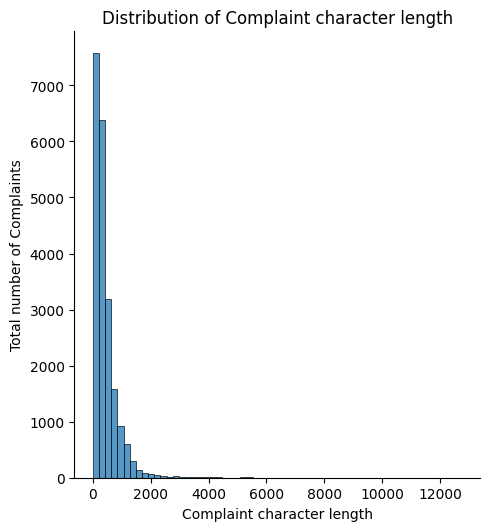

In [75]:
char_len = [len(clean_text) for clean_text in df_normalized['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

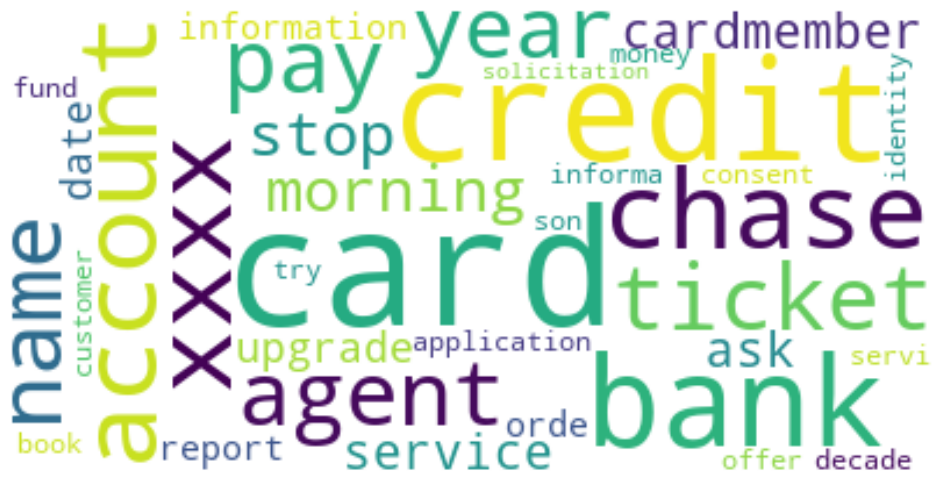

In [76]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=70, max_words=35, 
                      background_color="white", random_state=30, 
                      stopwords=stopwords).generate(str(df_normalized['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()